Notebook calculating the rotational population of normal H$_2$

In [1]:
%matplotlib inline
from pylab import *
from numpy import *

In [2]:
kB = 1.3806488e-23  # m^2 kg s^-2 K^-1
h = 6.62606957e-34  # m^2 kg s^-1
c = 299792458.      # m s^-1
eV2cm = 8065.54445  # http://physics.nist.gov/Pubs/AtSpec/node01.html
cm2J = 100*h*c

In [3]:
class Diatom:
    def __init__(self, omega_e = 0.0, omega_x_e = 0.0, omega_y_e = 0.0, B_e = 0.0,\
            alpha_e = 0.0, D_e = 0.0, Jmax=10):
        self.omega_e, self.omega_x_e = omega_e, omega_x_e
        self.omega_y_e = omega_y_e
        self.B_e, self.alpha_e, self.D_e = B_e, alpha_e, D_e
        self.Jmax=10

    def F(self, J, v=0):
        B = self.B_e - self.alpha_e*(v+0.5)
        D = self.D_e
        return B*J*(J+1) - D*(J*(J+1))**2

    def G(self, v):
        Y00 = self.B_e/4.+self.alpha_e*self.omega_e/(12*self.B_e) +\
                (self.alpha_e*self.omega_e)**2 / (144*self.B_e**3) - self.omega_x_e/4
        return Y00 + self.omega_e*(v+0.5)-self.omega_x_e*(v+0.5)**2+self.omega_y_e*(v+0.5)**3

    def _bfactor(self, T, J):
        return (2*J+1)*exp(-self.F(J)*cm2J/(kB*T))

    def Z(self, T):
        return sum(self._bfactor(T, arange(self.Jmax)), axis=1)

    def N(self, T, J):
        return self._bfactor(T, J)/self.Z(T)

In [4]:
class Hydrogen(Diatom):
    def __init__(self, *args):
        Diatom.__init__(self, *args)
        self.go = 3
        self.gp = 1
        self.T = -1.

    def set_temp(self, T):
        self.f_o = self.Zo(T)/(self.Zo(T)+self.Zp(T))
        self.T = T

    def p(self, J):
        return J % 2 == 0
    
    def o(self, J):
        return (J+1) % 2 == 0
    
    def _bfactor(self, T, J):
        T, J = array(T), atleast_1d(J)
        return exp(-outer(cm2J/(kB*T), self.F(J)))*\
            array((2*J+1)*(self.p(J)*self.gp + self.o(J)*self.go))[None, :]
    
    def Zo(self, T):
        J = arange(self.Jmax)
        Jo = J[self.o(J)]
        return sum(self._bfactor(T, Jo), axis=1)
    
    def Zp(self, T):
        J = arange(self.Jmax)
        Jp = J[self.p(J)]
        return sum(self._bfactor(T, Jp), axis=1)
    
    def N(self, T, J):
        iZop = outer((1-self.f_o)/self.Zp(T), self.p(J)) +\
            outer(self.f_o/self.Zo(T), self.o(J))
        return self._bfactor(T, J)*iZop 

In [5]:
H2 = Hydrogen(4401.213, 121.336, 0.8129, 60.8530, 3.0622, 4.71e-2)
H2.set_temp(300.)

The partition function can be written as a sum of ortho and para partition functions:
$$Z_o(T) = \sum_{J\rm odd} (2J+1)g_o\exp\left(-\frac{E_J}{k_BT}\right);\quad g_o=3$$
$$Z_p(T) = \sum_{J\rm even} (2J+1)g_p\exp\left(-\frac{E_J}{k_BT}\right);\quad g_p=1$$
$$Z(T) = Z_o(T) + Z_p(T)$$

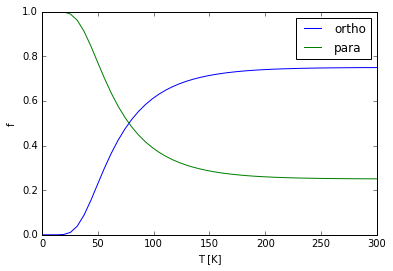

In [6]:
# equilibrium concentrations of para/ortho D2
T = linspace(1, 300)
plot(T, H2.Zo(T)/H2.Z(T), label="ortho")
plot(T, H2.Zp(T)/H2.Z(T), label="para")
xlabel("T [K]")
ylabel("f")
legend()

In [7]:
# fractions in normal H2
H2.set_temp(300.)

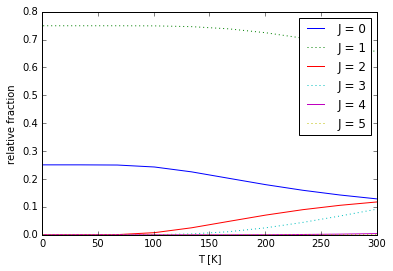

In [8]:
T = linspace(1, 300, 10)
for i in range(6):
    fmt = ":" if H2.o(i) else "-"
    plot(T, H2.N(T, i), fmt, label="J = %d"%i)
xlabel("T [K]")
ylabel("relative fraction")
legend()
savefig("fraction.pdf")

In [11]:
outdata = T
for i in range(6):
    outdata = vstack((outdata, H2.N(T, i).T))
savetxt("rotlevels.txt", outdata.T)

T = linspace(1, 300)
outdata = np.vstack((T, H2.Zo(T)/H2.Z(T), H2.Zp(T)/H2.Z(T)))
savetxt("orthopara.txt", outdata.T)
